# Imports:

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import random as rn
import tensorflow.keras as keras
import math

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import metrics, regularizers, optimizers


#import sklearn.metrics 

import matplotlib.pyplot as plt
import matplotlib as mpl

# The size of the plots.
mpl.rcParams['figure.figsize'] = (7,7)

# To have the plots inside the notebook "inlin" should be True. 
# If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib 

from sklearn.metrics import *
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Defining our model framework and creating functions for validation:

In [2]:
def pipline(inp_dim,
            n_nod,
            act_fun = 'relu',
            out_act_fun = 'sigmoid',
            opt_method = 'Adam',
            cost_fun = 'binary_crossentropy',
            lr_rate = 0.01, 
            lambd = 0.0, 
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for nod in n_nod:
        X = Dense(nod, 
                  activation = act_fun,
                  kernel_regularizer=regularizers.l2(lambd))(X)
        
    output = Dense(num_out, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method)
    
    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(lr = lr_rate, clipnorm = 1.0),
                  loss = cost_fun,
                  metrics=['accuracy', 'mse'])   
    
    return model

In [3]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             sensitivity = fraction of correctly classified positive cases
             specificity = fraction of correctly classified negative cases
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    sens = tp / nof_p
    spec = tn / nof_n
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'Sensitivity', 'Specificity', 'Loss']
    B = [acc, sens, spec, loss[0]]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print('\n','#'*50), acc

# Dividing our data into sets:

In [19]:
dataset = pd.read_csv('/Users/karltengelin/Documents/import_dataset_new.csv', delimiter = ';')

#Here we want to see where our prediction set starts (the set of data containing the pd:s we don't know)
count = 0 
for i in range(len(dataset)):
    if math.isnan(dataset.iloc[i]['default']):
        break
    count+=1
    
#Just to make sure we have found the start of our prediction set    
print(count)
print(dataset.iloc[count]['default'])
print(dataset.iloc[count-1]['default'])

#Training set and labels
#Set
t_dat = dataset.loc[1:count-1]
x_train = t_dat
#Labels
train_labels = t_dat['default'].values
d_train = train_labels

#Prediction set
p_dat = dataset.loc[count:len(dataset)]
x_pred = p_dat

89976
nan
0.0


# Removing unwanted columns (here we choose ONE of the following cells to run):

## Trying to remove as few columns as possible (this cell was used to produce the attached CSV-file):

In [20]:
#train set
x_train = x_train.drop(labels=['default', 'uuid', 'merchant_category','merchant_group', 'name_in_email', ], axis = 1)
x_train = x_train.values

#prediction set
x_pred = x_pred.drop(labels=['default', 'uuid', 'merchant_category','merchant_group', 'name_in_email', ], axis = 1)
x_pred = x_pred.values

## Removing columns that contain more than 50% NaN values:

In [ ]:
#train set
x_train = x_train.drop(labels=['default', 'uuid', 'merchant_category','merchant_group', 'name_in_email', 
                               'account_incoming_debt_vs_paid_0_24m', 'account_status', 
                               'account_worst_status_0_3m', 'account_worst_status_12_24m', 
                               'account_worst_status_3_6m', 'account_worst_status_6_12m', 
                               'avg_payment_span_0_3m', 'worst_status_active_inv'], axis = 1)
x_train = x_train.values

#prediction set
x_pred = x_pred.drop(labels=['default', 'uuid', 'merchant_category','merchant_group', 'name_in_email', 
                               'account_incoming_debt_vs_paid_0_24m', 'account_status', 
                               'account_worst_status_0_3m', 'account_worst_status_12_24m', 
                               'account_worst_status_3_6m', 'account_worst_status_6_12m', 
                               'avg_payment_span_0_3m', 'worst_status_active_inv'], axis = 1)
x_pred = x_pred.values

## Normalizing input data to have zero mean and unit variance:

In [21]:
x_train = StandardScaler().fit_transform(x_train)

# Training our MLP model and using K-fold cross validation to ensure generalization:

K-fold 1 of 10

 ########## STATISTICS for Training Data ########## 

Accuracy   0.9856625955518233
Sensitivity   0.04013663535439795
Specificity   0.9995363757110994
Loss   0.05982979014515877

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.9865525672371638
Sensitivity   0.02564102564102564
Specificity   0.9992118004729197
Loss   0.05389457568526268

 ##################################################
K-fold 2 of 10

 ########## STATISTICS for Training Data ########## 

Accuracy   0.9857243414796795
Sensitivity   0.037132987910189985
Specificity   0.9994863378393616
Loss   0.05922059342265129

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.9849966659257613
Sensitivity   0.007692307692307693
Specificity   0.9993234100135318
Loss   0.06265977025032043

 ##################################################
K-fold 3 of 10

 ########## STATISTI

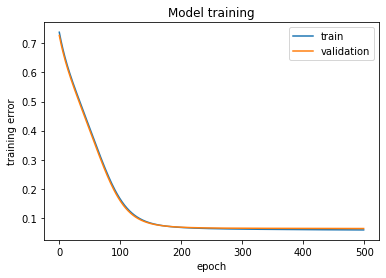

CPU times: user 1h 38min 17s, sys: 2min 3s, total: 1h 40min 21s
Wall time: 32min 50s


In [22]:
%%time

#training our model
scores_val = []
scores_train = []
iterat= 0
K = 10 #meaning that we test on 0.9 of data and validate on 0.1
cv = KFold(n_splits=K, random_state=42, shuffle=False)

for train_index, test_index in cv.split(x_train):
    print('K-fold ' + str(iterat+1) + ' of ' + str(K))
    
    x_t, x_val, d_t, d_val = x_train[train_index], x_train[test_index], d_train[train_index], d_train[test_index]

    # Defining the network, cost function and minimization method
    INPUT = {'inp_dim': x_t.shape[1],         
             'n_nod': [30,30,30],                      #number of nodes in hidden layer (chosen arbitrary)
             'act_fun': 'tanh',                        #activation functions for the hidden layer
             'out_act_fun': 'sigmoid',                 #output activation function
             'opt_method': 'Adam',                     #minimization method
             'cost_fun': 'binary_crossentropy',        #error function
             'lr_rate': 0.0005 ,                       #learningrate, this rate was chosen based on 
                                                       #training-and validation error plots
             'num_out' : 1 }                           

    # creating the model
    model = pipline(**INPUT)

    # Printing a summary of the model
    #model.summary()

    # Training the model
    estimator = model.fit(x_t, d_t,
                          epochs = 500,      
                          validation_data=(x_val, d_val),
                          batch_size = x_t.shape[0],        # Batch size = all data (batch learning)
                          #batch_size=50,                   # Batch size for true SGD
                          verbose = 0)

    # Call the stats function to print out statistics for classification problems
    _,acc_t = stats_class(x_t, d_t, 'Training', model)
    _,acc_v = stats_class(x_val, d_val, 'Validation', model)
    
    # Append accuracy scores so we can validate results
    scores_val.append(acc_v)
    scores_train.append(acc_t)
    
    iterat+=1
    if iterat == 10:
        # Plotting the last learning curve as an example
        plt.plot(estimator.history['loss'])
        plt.plot(estimator.history['val_loss'])
        plt.title('Model training')
        plt.ylabel('training error')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc=0)
        plt.show()
        #If we want to save the figure:
        #plt.savefig('/Users/karltengelin/Documents/Train_val_error_case_study_klarna.png',format='png')

   

In [23]:
print('Average validation accuracy: ' + str(np.mean(scores_val)))
print('Average training accuracy: ' + str(np.mean(scores_train)))

Average validation accuracy: 0.9854292531335245
Average training accuracy: 0.9857244295487189


# Doing our prediction:

In [24]:
#transforming to zero mean and unit variance
x_pred = StandardScaler().fit_transform(x_pred)

In [25]:
#prediction
pred_labels = model.predict(x_pred)

#matching our uuid:s to our labels and storing in csv-file
uuid = dataset.iloc[count:len(dataset)]['uuid'].values

listing = []
for i in range(len(uuid)):
    listing.append([uuid[i],pred_labels[i].item()])

df = pd.DataFrame(listing)
df.columns = ["uuid", "pd"]
#csv_data = df.to_csv('/Users/karltengelin/Documents/probability_of_defaults.csv',index=False, sep=';')
csv_data = df.to_csv(index=False, sep =';')

In [26]:
print(max(pred_labels))
print(min(pred_labels))
#we see that we pass the sanity check of having values inbetween 0 and 1

[0.99895036]
[0.00031391]


In [29]:
#Checking how many of our uuid:s that have a higher than 50% probability of default
d50 = 0
for i in pred_labels:
    if i > 0.50:
        print(i)
        d50 +=1
print('Ratio of defaulted uuid:s in prediction set: ' + str(d50/10000))
print('Ratio of defaulted uuid:s in test set: ' + str(1288/89976))
#These results are a bit worrying since a much smaller portion of the prediction set are thought to default, 
# this might be an indication that we need to create a one hot encoding for the 
# merchant_cathegory and merchant_group columns. If we lower the threshold to assuming that uuid:s with a pd > 15% 
# will default we get approximately the same default ratio (1.4-1.5%) as for the training set

[0.53991455]
[0.65417755]
[0.53218025]
[0.60405356]
[0.61388874]
[0.67580533]
[0.86604416]
[0.9986354]
[0.76589715]
[0.74693835]
[0.5728623]
[0.75853]
[0.5698374]
[0.7698958]
[0.59286046]
[0.99895036]
[0.75551945]
Ratio of defaulted uuid:s in prediction set: 0.0017
Ratio of defaulted uuid:s in test set: 0.014314928425357873


In [ ]:
#Comments:
# I made a try without columns that contained to many missing values (>40%) and got the following 
# min_pred_labels and max_pred_labels: max[0.9990], min[0.0003]
# The model seemed to produce similar results when not including low-quality columns as when they were included
# hence we might as well keep them in the model.

# One could try to use PCA to do a predictive model instead to see if we get different results 
# that could prove more realistic.
# This would be a way of simplifying the problem, but since we got high train and 
# validation scores for our full dataset I opted to use the full dataset.
# If one would want to use PCA the script following header 'PCA:' describes how to do PCA

# ____________________________________________

# PCA:

In [13]:
x_train = x_train.drop(labels=['default', 'uuid', 'merchant_category','merchant_group', 'name_in_email', ], axis = 1)
x_train = StandardScaler().fit_transform(x_train)

#Extracting the 5 most principal components
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 
                          'principal component 3', 'principal component 4', 
                          'principal component 5'])
print(principalDf)
# We can then use principalDf the same way as we used training set in our model above
# (and also we would need to do PCA on prediction set aswell)

array([[-3.46166596e-01, -4.12499492e-02, -2.35266618e-01, ...,
         1.09644057e-01, -4.28380119e-01, -1.19433870e-03],
       [-3.46166596e-01, -4.12499492e-02, -2.35266618e-01, ...,
         9.57808894e-01, -7.50296435e-01, -6.40949743e-01],
       [-3.46166596e-01,  9.51595938e-04, -1.19735218e-03, ...,
         3.19314970e+00,  8.24342626e-02, -6.40949743e-01],
       ...,
       [-3.46166596e-01, -4.12499492e-02, -2.35266618e-01, ...,
         9.05386760e-02,  6.65031013e-01, -1.19433870e-03],
       [-3.46166596e-01, -4.12499492e-02, -2.35266618e-01, ...,
        -2.87273596e-01, -6.70286702e-01, -1.19433870e-03],
       [-3.46166596e-01,  9.51595938e-04, -1.19735218e-03, ...,
        -3.44544997e-01,  7.13511721e-01, -1.19433870e-03]])